In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.preprocessing
from sklearn.metrics import r2_score
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

C:\Users\soham\AppData\Local\Temp/ipykernel_3032/2981071820.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


                     hour  dayofweek  quarter  month  year  dayofyear  \
Datetime                                                                
2004-12-31 01:00:00     1          4        4     12  2004        366   
2004-12-31 02:00:00     2          4        4     12  2004        366   
2004-12-31 03:00:00     3          4        4     12  2004        366   
2004-12-31 04:00:00     4          4        4     12  2004        366   
2004-12-31 05:00:00     5          4        4     12  2004        366   
...                   ...        ...      ...    ...   ...        ...   
2018-01-01 20:00:00    20          0        1      1  2018          1   
2018-01-01 21:00:00    21          0        1      1  2018          1   
2018-01-01 22:00:00    22          0        1      1  2018          1   
2018-01-01 23:00:00    23          0        1      1  2018          1   
2018-01-02 00:00:00     0          1        1      1  2018          2   

                     dayofmonth  weekofyear   AEP_

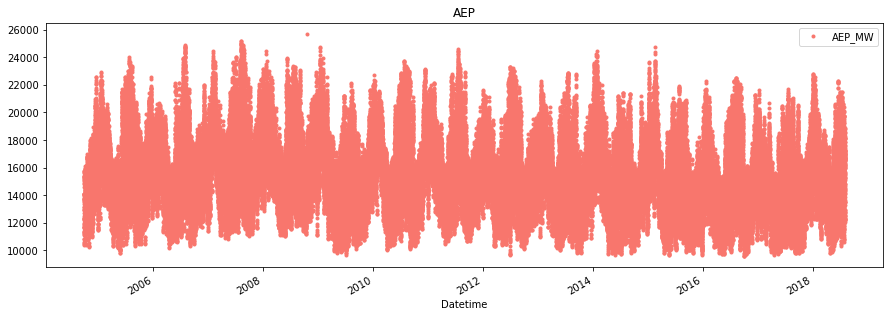

25695.0 9581.0


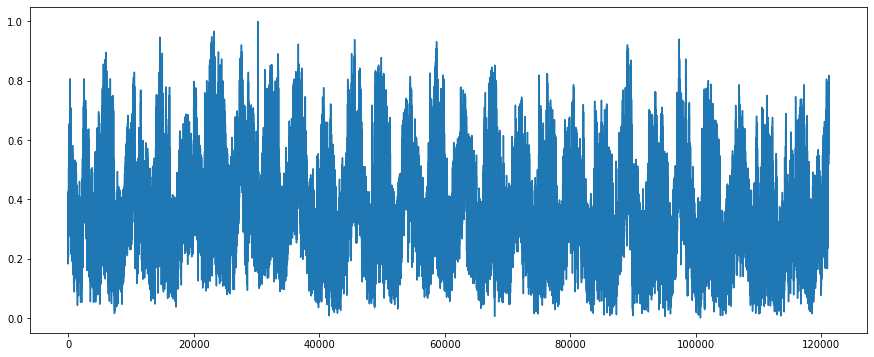

In [12]:
AEP = pd.read_csv('AEP_hourly.csv', index_col=[0], parse_dates=[0])

mau = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
bieudo = AEP.plot(style='.',figsize=(15,5), color=mau[0], title='AEP')

#Data transformation
def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(AEP, label='AEP_MW')
features_and_target = pd.concat([X, y], axis=1)
print(features_and_target)
plt.show()

plt.figure(figsize=(15,6))
data_csv = AEP.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: (x-min_value) / scalar, dataset))
plt.plot(dataset)
print(max_value, min_value)

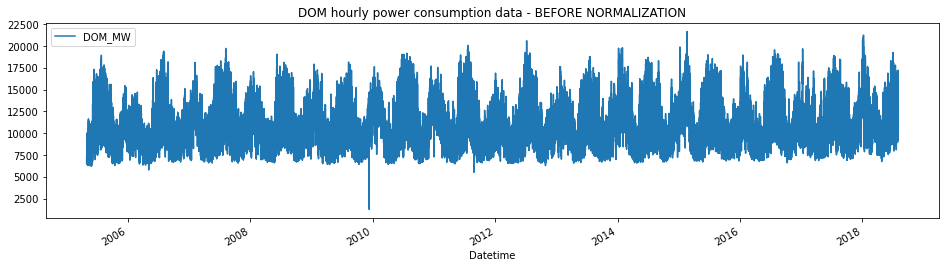

In [13]:
#choosing DOM_hourly.csv data for analysis
fpath='DOM_hourly.csv'

#Let's use datetime(2012-10-01 12:00:00,...) as index instead of numbers(0,1,...)
#This will be helpful for further data analysis as we are dealing with time series data
df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
df.head()

#checking missing data
df.isna().sum()

#Data visualization

df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

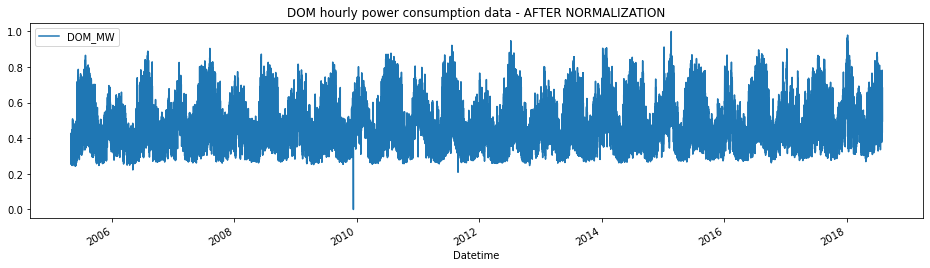

In [14]:
#Normalize DOM hourly power consumption data

def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

#Visualize data after normalization

df_norm.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

In [15]:
# train data for deep learning models

def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i - seq_len: i, 0])
        y_train.append(stock.iloc[i, 0])

    # 1 last 6189 days are going to be used in test
    X_test = X_train[110000:]
    y_test = y_train[110000:]

    # 2 first 110000 days are going to be used in training
    X_train = X_train[:110000]
    y_train = y_train[:110000]

    # 3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # 4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))

    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))

    return [X_train, y_train, X_test, y_test]


In [16]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)


X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


Before moving on to the **RNN model**, a good explaination for beginners to machine learning using RRN models is available at this [link](https://towardsdatascience.com/learn-how-recurrent-neural-networks-work-84e975feaaf7) 

In [17]:
#RNN model

rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 20, 40)            1680      
                                                                 
 dropout_6 (Dropout)         (None, 20, 40)            0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 20, 40)            3240      
                                                                 
 dropout_7 (Dropout)         (None, 20, 40)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dropout_8 (Dropout)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [18]:
#r2 score for the values predicted by the above trained SIMPLE RNN model

rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

193/193 [==============================] - 1s 4ms/step
R2 Score of RNN model =  0.9418956753540856


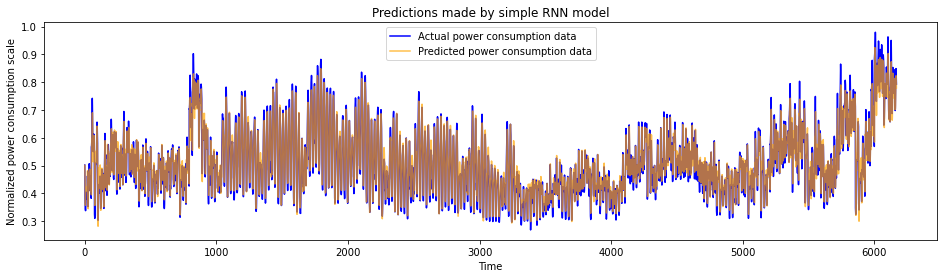

In [19]:
# compare the actual values vs predicted values by plotting a graph

def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16, 4))
    plt.plot(test, color='blue', label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange', label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()


plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")


That's the simple RNN model used against the energy data, finishing off with a plot the predicted values against the actual values.

Next, we move on to LSTM model as highlighted in the 'Towards Data Science' article on Recurrent Neural Network models.

In [20]:
#train model for LSTM

lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20, 40)            6720      
                                                                 
 dropout_9 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_4 (LSTM)               (None, 20, 40)            12960     
                                                                 
 dropout_10 (Dropout)        (None, 20, 40)            0         
                                                                 
 lstm_5 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_11 (Dropout)        (None, 40)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [21]:
#r2 score for the values predicted by the above trained LSTM model
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)


193/193 [==============================] - 3s 7ms/step
R^2 Score of LSTM model =  0.9482797690539793


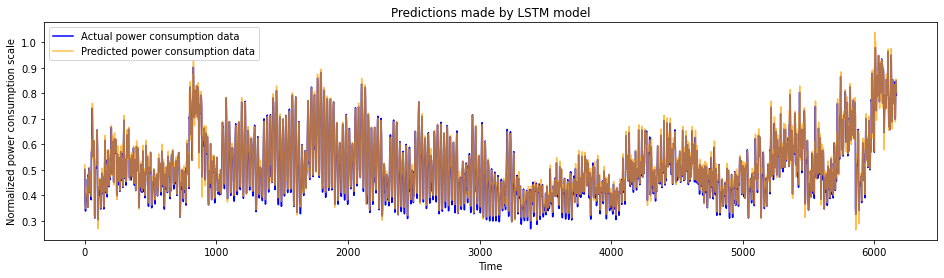

In [22]:
#actual values vs predicted values by plotting a graph
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

As you will observe from the plot graph which compares the predicted values to the data set, the trained LTSM model provides an accurate prediction of energy values.

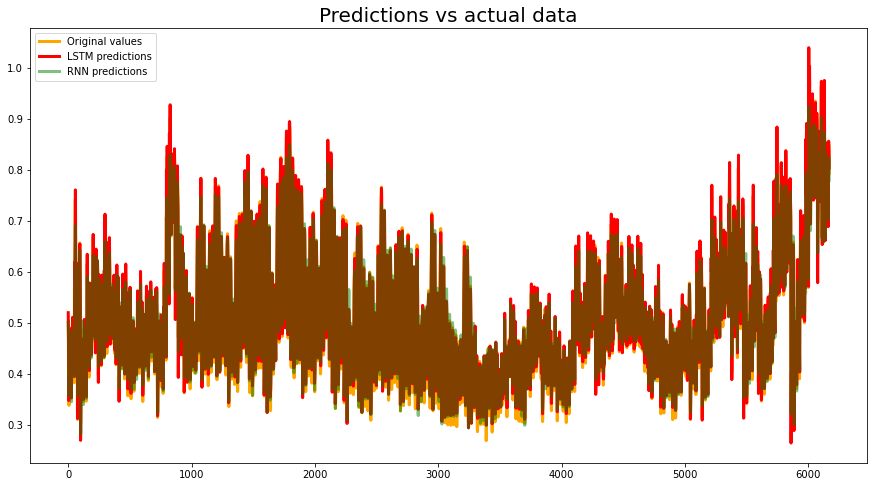

In [23]:
#RNN, LSTM model by plotting data in a single graph
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()

And finally, we can compare the RNN model against the LTSM model by plotting them on a single graph with the actual data.